Кредитный скоринг ЦМФ. Разживин Егор

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier


In [3]:
def get_file(filename: str) -> pd.DataFrame:
    return pd.read_csv(f'D:/it/cmf/credit_scoring/{filename}')

In [46]:
X_test0 = get_file('X_test.csv')
X_train = get_file('X_train.csv')
y_test0 = get_file('y_test_sample.csv')
y_train = get_file('y_train.csv')

In [47]:
X_train.isna().mean()*100

credit_card_utilization       0.000
age                           0.000
overdue_30_59_days            0.000
debt_to_income                0.000
monthly_income               19.973
credits_loans                 0.000
overdue__more_than_90_days    0.000
mortgage_loans                0.000
overdue_60_89_days            0.000
family_members                2.669
dtype: float64

In [5]:
X_train['target'] = y_train

Распределение фичей

Корр матрица

<AxesSubplot:>

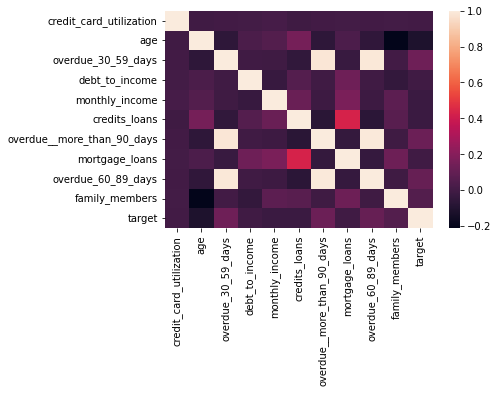

In [6]:
sns.heatmap(X_train.corr(), annot = False, cmap = 'rocket')

Распределение таргета

<AxesSubplot:xlabel='target', ylabel='count'>

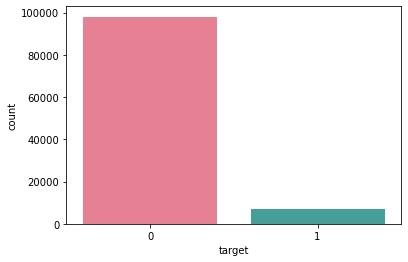

In [7]:
sns.countplot(x=X_train['target'], palette='husl')

Распределение возраста для таргета

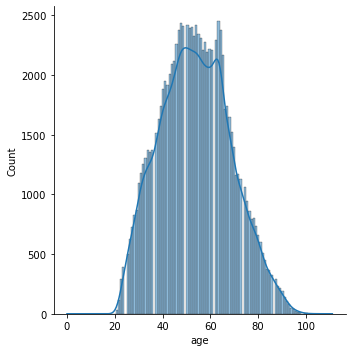

In [8]:
sns.displot(x=X_train.loc[X_train['target']==0]['age'], bins=120, kde=True)

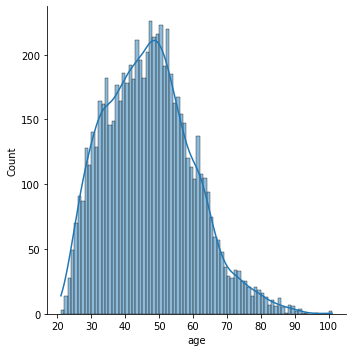

In [9]:
sns.displot(x=X_train.loc[X_train['target']==1]['age'], bins=80, kde=True)

Распределение дохода для таргета (взял логарифм, так как разброс точек в доходе очень большой)

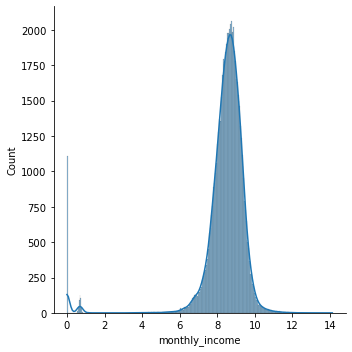

In [10]:
sns.displot(x=np.log(X_train.loc[X_train['target']==0]['monthly_income']+1), kde=True)

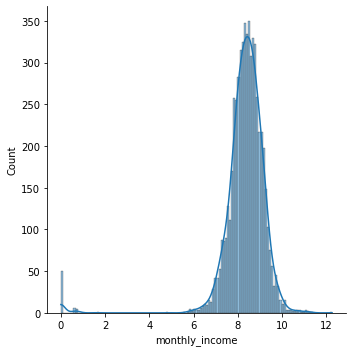

In [11]:
sns.displot(x=np.log(X_train.loc[X_train['target']==1]['monthly_income']+1), kde=True)

Debt/income ratio

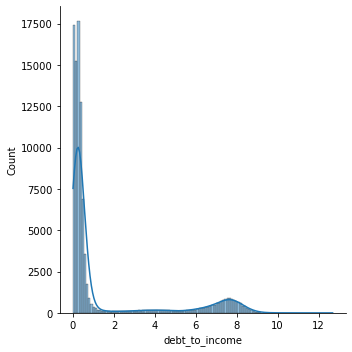

In [15]:
sns.displot(x=np.log(X_train.loc[X_train['target']==0]['debt_to_income']+1), bins=120, kde=True)

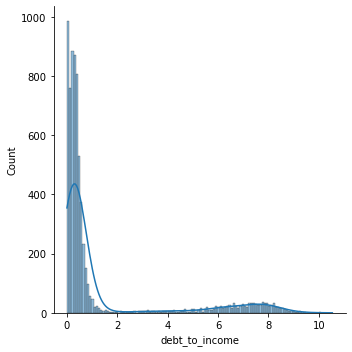

In [19]:
sns.displot(x=np.log(X_train.loc[X_train['target']==1]['debt_to_income']+1), bins=120, kde=True)

Credit loans

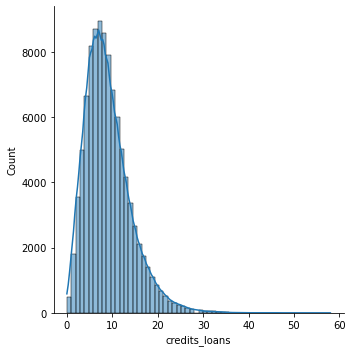

In [25]:
sns.displot(x=X_train.loc[X_train['target']==0]['credits_loans'], bins=60, kde=True)

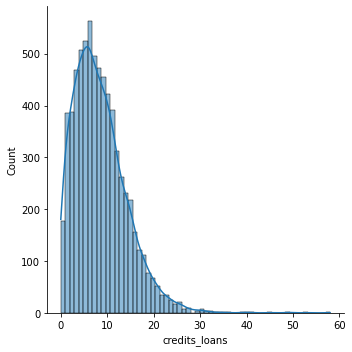

In [26]:
sns.displot(x=X_train.loc[X_train['target']==1]['credits_loans'], bins=60, kde=True)

Mortgage loans

<AxesSubplot:xlabel='mortgage_loans', ylabel='count'>

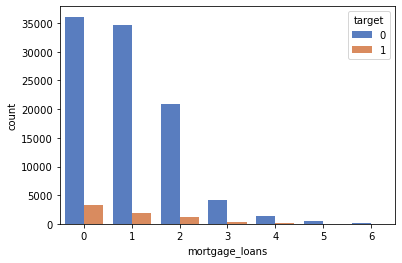

In [43]:
sns.countplot(data=X_train[X_train['mortgage_loans']<7], x='mortgage_loans', hue='target', palette = "muted")

На данном этапе заполним None нулями

In [44]:
X_test0.fillna(0, inplace=True)
X_train.fillna(0, inplace=True)

In [4]:
from sklearn.preprocessing import StandardScaler

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test0_scaled = scaler.transform(X_test0.iloc[:, 1:])

In [7]:
X_test0_scaled = pd.DataFrame(X_test0_scaled)
X_train_scaled = pd.DataFrame(X_train_scaled)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
X_train_scaled, y_train, shuffle=True, test_size=0.3)

1. Логистическая регрессия

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score

In [60]:
model_log_reg = LogisticRegression(random_state = 101)

In [61]:
grid={"C":np.logspace(-3,3,7)}
model_log_reg_cv=GridSearchCV(model_log_reg, grid, cv=10, verbose=1)
model_log_reg_cv.fit(X_train, y_train['target'])

Fitting 10 folds for each of 7 candidates, totalling 70 fits


GridSearchCV(cv=10, estimator=LogisticRegression(random_state=101),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             verbose=1)

In [62]:
model_log_reg_cv.best_params_

{'C': 100.0}

In [10]:
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [66]:
print('roc_auc:', roc_auc_score(y_test['target'], model_log_reg_cv.predict_proba(X_test)[:, 1:]))
print('accuracy_score:', accuracy_score(y_test['target'], model_log_reg_cv.predict(X_test)))
print('precision_score:', precision_score(y_test['target'], model_log_reg_cv.predict(X_test)))
print('recall_score:', recall_score(y_test['target'], model_log_reg_cv.predict(X_test)))
print('f1_score:', f1_score(y_test['target'], model_log_reg_cv.predict(X_test)))

roc_auc: 0.6965025036594013
accuracy_score: 0.9341324961151809
precision_score: 0.5733333333333334
recall_score: 0.04097189137684612
f1_score: 0.07647843485993776


In [65]:
pd.DataFrame(confusion_matrix(y_test['target'], model_log_reg_cv.predict(X_test)))

,0,1
0,29327,66
1,2059,81


In [64]:
fpr_log_reg, tpr_log_reg, threshold_log_reg = metrics.roc_curve(y_test['target'], model_log_reg_cv.predict_proba(X_test)[:, 1:])

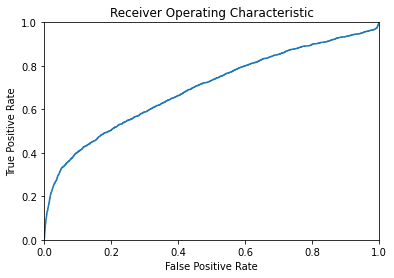

In [65]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_log_reg, tpr_log_reg)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [73]:
y_pred_logit = model_log_reg_cv.predict_proba(X_test0_scaled)[:, 1:]

In [74]:
y_pred_logit = pd.DataFrame(y_pred_logit)

In [76]:
y_test0['target'] = y_pred_logit
y_test0.to_csv('pred_logit.csv', index = False)

Score: 0.69432

2. KNN

In [77]:
from sklearn.neighbors import KNeighborsClassifier

In [68]:
k_range = list(range(1, 10))
param_grid_knn = dict(n_neighbors=k_range)
model_knn = KNeighborsClassifier()
grid_knn = GridSearchCV(model_knn, param_grid_knn,
                        cv=10, scoring='roc_auc')
grid_knn.fit(X_train, y_train['target'])

Fitting 10 folds for each of 9 candidates, totalling 90 fits


GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='roc_auc', verbose=1)

In [69]:
grid_knn.best_params_

{'n_neighbors': 9}

In [70]:
print('roc_auc:', roc_auc_score(y_test['target'], grid_knn.predict_proba(X_test)[:, 1:]))
print('accuracy_score:', accuracy_score(y_test['target'], grid_knn.predict(X_test)))
print('precision_score:', precision_score(y_test['target'], grid_knn.predict(X_test)))
print('recall_score:', recall_score(y_test['target'], grid_knn.predict(X_test)))
print('f1_score:', f1_score(y_test['target'], grid_knn.predict(X_test)))

roc_auc: 0.6992584939754103
accuracy_score: 0.9344179113944122
precision_score: 0.5441595441595442
recall_score: 0.09099571224392568
f1_score: 0.15591836734693879


In [81]:
pd.DataFrame(confusion_matrix(y_test['target'], grid_knn.predict(X_test)))

,0,1
0,29249,144
1,1952,188


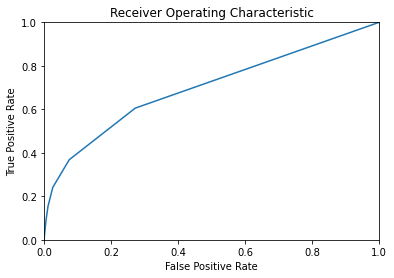

In [71]:
fpr_knn, tpr_knn, threshold_knn = metrics.roc_curve(y_test['target'], grid_knn.predict_proba(X_test)[:, 1:])
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_knn, tpr_knn)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [86]:
y_pred_knn = grid_knn.predict_proba(X_test0_scaled)[:, 1:]
y_pred_knn = pd.DataFrame(y_pred_knn)
y_test0['target'] = y_pred_knn
y_test0.to_csv('pred_knn.csv', index = False)

Score: 0.70883

3. Decision Trees

In [72]:
model_decision_tree = DecisionTreeClassifier(random_state = 101)
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]
param_decision_tree = dict(criterion = criterion, max_depth = max_depth)
grid_decision_tree = GridSearchCV(model_decision_tree, 
            param_decision_tree, cv=10, scoring='roc_auc', verbose=1)
grid_decision_tree.fit(X_train, y_train['target'])

Fitting 10 folds for each of 12 candidates, totalling 120 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=101),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12]},
             scoring='roc_auc', verbose=1)

In [73]:
grid_decision_tree.best_params_

{'criterion': 'entropy', 'max_depth': 6}

In [75]:
decision_tree_pred = grid_decision_tree.predict(X_test)
print('roc_auc:', roc_auc_score(y_test['target'], grid_decision_tree.predict_proba(X_test)[:, 1:]))
print('accuracy_score:', accuracy_score(y_test['target'],  decision_tree_pred))
print('precision_score:', precision_score(y_test['target'],  decision_tree_pred))
print('recall_score:', recall_score(y_test['target'],  decision_tree_pred))
print('f1_score:', f1_score(y_test['target'],  decision_tree_pred))

roc_auc: 0.8488129043999668
accuracy_score: 0.9368280848634764
precision_score: 0.5783308931185944
recall_score: 0.1881848499285374
f1_score: 0.2839683680805176


In [90]:
pd.DataFrame(confusion_matrix(y_test['target'], grid_decision_tree.predict(X_test)))

,0,1
0,29112,281
1,1745,395


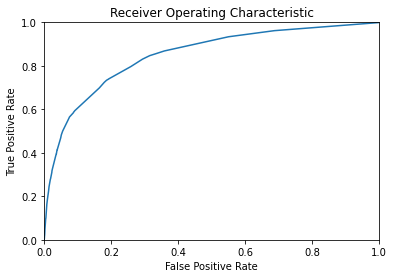

In [76]:
fpr_decision_tree, tpr_decision_tree, threshold_decision_tree = metrics.roc_curve(y_test['target'], grid_decision_tree.predict_proba(X_test)[:, 1:])
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_decision_tree, tpr_decision_tree)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [92]:
y_pred_decision_tree = grid_decision_tree.predict_proba(X_test0_scaled)[:, 1:]
y_pred_decision_tree = pd.DataFrame(y_pred_decision_tree)
y_test0['target'] = y_pred_decision_tree
y_test0.to_csv('pred_decision_tree.csv', index = False)

Score: 0.84381

4. Random Forest.


In [6]:
from sklearn.ensemble import RandomForestClassifier

In [79]:
model_rf = RandomForestClassifier(max_depth = 10, n_estimators = 800)
model_rf.fit(X_train, y_train['target'])

RandomForestClassifier(max_depth=10, n_estimators=800)

In [114]:
#n_estimators_rf = [int(x) for x in np.linspace(200, 800, 4)]
#max_depth_rf = [int(x) for x in np.linspace(10, 110, 4)]

#params_rf = dict(n_estimators = n_estimators_rf, max_depth = max_depth_rf)
#grid_rf = GridSearchCV(model_rf, params_rf, cv=2, scoring='roc_auc', verbose=1)
#grid_rf.fit(X_train_scaled, y_train['target'])

Fitting 2 folds for each of 16 candidates, totalling 32 fits


GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=101),
             param_grid={'max_depth': [10, 43, 76, 110],
                         'n_estimators': [200, 400, 600, 800]},
             scoring='roc_auc', verbose=1)

In [116]:
grid_rf.best_params_

{'max_depth': 10, 'n_estimators': 800}

In [80]:
rf_pred = model_rf.predict(X_test)
print('roc_auc:', roc_auc_score(y_test['target'], model_rf.predict_proba(X_test)[:, 1:]))
print('accuracy_score:', accuracy_score(y_test['target'],  rf_pred))
print('precision_score:', precision_score(y_test['target'],  rf_pred))
print('recall_score:', recall_score(y_test['target'],  rf_pred))
print('f1_score:', f1_score(y_test['target'],  rf_pred))

roc_auc: 0.8598150146274076
accuracy_score: 0.9376526178923668
precision_score: 0.6099173553719008
recall_score: 0.1757979990471653
f1_score: 0.2729289940828402


In [81]:
pd.DataFrame(confusion_matrix(y_test['target'], model_rf.predict(X_test)))

,0,1
0,29198,236
1,1730,369


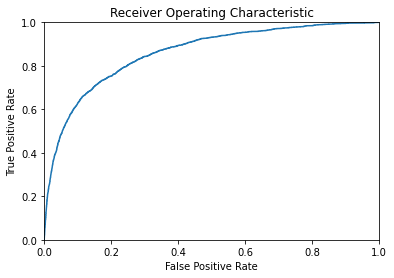

In [82]:
fpr_rf, tpr_rf, threshold_rf = metrics.roc_curve(y_test['target'], model_rf.predict_proba(X_test)[:, 1:])
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_rf, tpr_rf)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [99]:
y_pred_rf = model_rf.predict_proba(X_test0_scaled)[:, 1:]
y_pred_rf = pd.DataFrame(y_pred_rf)
y_test0['target'] = y_pred_rf
y_test0.to_csv('pred_rf.csv', index = False)

Score: 0.86245

5. DNN

In [11]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense

In [12]:
model = keras.Sequential(name="lol")
model.add(Dense(8, input_shape = (10,), activation="relu", name="layer1"))
model.add(Dense(4, activation="relu", name="layer2"))
model.add(Dense(3, activation="relu", name="layer3"))
model.add(Dense(1, activation='sigmoid', name="layer4"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']

In [13]:
model.fit(X_train, y_train['target'], epochs=60, batch_size=10)

Epoch 1/60
7358/7358 [==============================] - 30s 4ms/step - loss: 0.2231 - accuracy: 0.9299
Epoch 2/60
7358/7358 [==============================] - 27s 4ms/step - loss: 0.1912 - accuracy: 0.9335
Epoch 3/60
7358/7358 [==============================] - 26s 4ms/step - loss: 0.1897 - accuracy: 0.9363
Epoch 4/60
7358/7358 [==============================] - 26s 4ms/step - loss: 0.1893 - accuracy: 0.9361
Epoch 5/60
7358/7358 [==============================] - 26s 4ms/step - loss: 0.1889 - accuracy: 0.9367
Epoch 6/60
7358/7358 [==============================] - 25s 3ms/step - loss: 0.1885 - accuracy: 0.9368
Epoch 7/60
7358/7358 [==============================] - 26s 4ms/step - loss: 0.1881 - accuracy: 0.9368
Epoch 8/60
7358/7358 [==============================] - 27s 4ms/step - loss: 0.1881 - accuracy: 0.9367
Epoch 9/60
7358/7358 [==============================] - 26s 4ms/step - loss: 0.1879 - accuracy: 0.9369
Epoch 10/60
7358/7358 [==============================] - 28s 4ms/step - l

In [43]:
dnn_pred = model.predict(X_test)
dnn_pred = pd.DataFrame(dnn_pred)
dnn_pred.rename(columns={0:'target'}, inplace=True)
dnn_pred['target'] = np.where(dnn_pred['target']>0.2, 1, 0)

986/986 [==============================] - 3s 3ms/step


In [46]:
pd.DataFrame(confusion_matrix(y_test['target'], dnn_pred))

,0,1
0,27808,1626
1,1095,1004


In [47]:
print('roc_auc:', roc_auc_score(y_test['target'], dnn_pred))
print('accuracy_score:', accuracy_score(y_test['target'],  dnn_pred))
print('precision_score:', precision_score(y_test['target'],  dnn_pred))
print('recall_score:', recall_score(y_test['target'],  dnn_pred))
print('f1_score:', f1_score(y_test['target'],  dnn_pred))

roc_auc: 0.7115403870443359
accuracy_score: 0.9137094472457425
precision_score: 0.3817490494296578
recall_score: 0.4783230109575989
f1_score: 0.4246140833157116


986/986 [==============================] - 3s 3ms/step


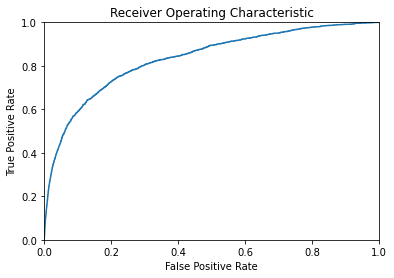

In [58]:
fpr_dnn, tpr_dnn, threshold_dnn = metrics.roc_curve(y_test['target'], model.predict(X_test))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_dnn, tpr_dnn)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [25]:
y_pred_dnn = model.predict(X_test0_scaled)
y_pred_dnn = pd.DataFrame(y_pred_dnn)
y_test0['target'] = y_pred_dnn
y_test0.to_csv('pred_dnn.csv', index = False)

1215/1215 [==============================] - 3s 3ms/step


Score: 0.83769

6. Gradient Boosting 

In [48]:
from sklearn.ensemble import GradientBoostingRegressor

In [50]:
model_gbc = GradientBoostingRegressor(learning_rate=0.2, n_estimators=100, random_state = 101)
model_gbc.fit(X_train, y_train['target'])

GradientBoostingRegressor(learning_rate=0.2, random_state=101)

In [16]:
learning_rate_gbc = [0.01, 0.05, 0.2]
max_depth_gbc = [int(x) for x in np.logspace(2, 20, 2)]
n_estimators_gbc = [int(x) for x in np.linspace(10, 100, 2)]
params_gbc = dict(learning_rate = learning_rate_gbc,
                  n_estimators = n_estimators_gbc)
grid_gbc = GridSearchCV(model_gbc, params_gbc, cv = 3,
                        scoring = 'roc_auc', verbose = 1)
grid_gbc.fit(X_train_scaled, y_train['target'])

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=101),
             param_grid={'learning_rate': [0.01, 0.05, 0.2],
                         'n_estimators': [10, 100]},
             scoring='roc_auc', verbose=1)

In [17]:
grid_gbc.best_params_

{'learning_rate': 0.2, 'n_estimators': 100}

In [54]:
y_gbc = model_gbc.predict(X_test)
y_gbc = pd.DataFrame(y_gbc)
y_gbc.rename(columns={0:'target'}, inplace=True)
y_gbc['target'] = np.where(y_gbc['target'] > 0.2, 1, 0)

In [55]:
pd.DataFrame(confusion_matrix(y_test['target'], y_gbc))

,0,1
0,27779,1655
1,1036,1063


In [83]:
print('roc_auc:', roc_auc_score(y_test['target'], model_gbc.predict(X_test)))
print('accuracy_score:', accuracy_score(y_test['target'],  y_gbc))
print('precision_score:', precision_score(y_test['target'],  y_gbc))
print('recall_score:', recall_score(y_test['target'],  y_gbc))
print('f1_score:', f1_score(y_test['target'],  y_gbc))

roc_auc: 0.8578372368402779
accuracy_score: 0.9146608315098468
precision_score: 0.3910963944076527
recall_score: 0.5064316341114816
f1_score: 0.44135353954743617


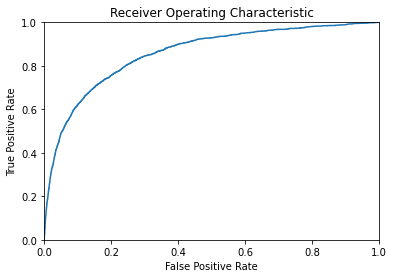

In [85]:
fpr_gbc, tpr_gbc, threshold_gbc = metrics.roc_curve(y_test['target'], model_gbc.predict(X_test))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_gbc, tpr_gbc)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [138]:
y_pred_gbc = pd.DataFrame(y_pred_gbc)
y_pred_gbc_test_final = pd.concat([X_test_index, y_pred_gbc], axis = 1)
y_pred_gbc_test_final.rename(columns={0:'target'}, inplace=True)
y_pred_gbc_test_final.to_csv('pred_week2_gbc.csv', index = False)

Score: 0.82324


Сравним модельки и получим, что с rf скор выше, поэтому дальше будем использовать rf

Дальше я попробовал почистить данные (в основном отсекал хвосты, содержащие слишком большие значения, однако, скор выше .861 выбить не получилось).
На мой взгляд, ухудшение модели после чистки  данных связано с тем, что трейн и тест имеют практически одинаковое распределение по всем фичам - следовательно, отсечение хвостов совсем не однозначно повлияет на результат модели
Также пробовал оверсэмплить и андерсэмплить через RandomOverSampler - там скор примерно в районе .860-.861


Перейдем к итоговому feature engineering'у. Я добавил две дополнительные колонки 'add_0', 'add_1', в которых стоят 0, если в 'monthly_income', 'family_members' не None, и 1 иначе. Категориальных фичей у нас нет, интересных зависимостей на графиках не обнаружено, поэтому feature engineering получился не самый богатый.

In [7]:
X_test = get_file('X_test.csv')
X_train = get_file('X_train.csv')
y_test = get_file('y_test_sample.csv')
y_train = get_file('y_train.csv')

In [8]:
X_train['add_0'] = np.where(X_train['monthly_income'] > -1, 1, 0)
X_train['add_1'] = np.where(X_train['family_members'] > -1, 1, 0)
X_test['add_0'] = np.where(X_test['monthly_income'] > -1, 1, 0)
X_test['add_1'] = np.where(X_test['family_members'] > -1, 1, 0)

In [9]:
X_train['total_overdue'] = np.cbrt(X_train['overdue_30_59_days']*X_train['overdue_60_89_days']*X_train['overdue__more_than_90_days'])
X_test['total_overdue'] = np.cbrt(X_test['overdue_30_59_days']*X_test['overdue_60_89_days']*X_test['overdue__more_than_90_days'])

In [10]:
X_train['loans'] = np.sqrt(X_train['mortgage_loans']*X_train['credits_loans'])
X_test['loans'] = np.sqrt(X_test['mortgage_loans']*X_test['credits_loans'])

In [11]:
X_train['high_age'] = np.where(X_train['age'] >= 65, 1, 0)
X_test['high_age'] = np.where(X_test['age'] >= 65, 1, 0)

In [14]:
X_train['income_feature'] = np.sqrt(X_train['monthly_income']*X_train['debt_to_income'])
X_test['income_feature'] = np.sqrt(X_test['monthly_income']*X_test['debt_to_income'])

In [13]:
X_train['monthly_income'].fillna(0, inplace=True)
X_train['family_members'].fillna(0, inplace=True)
X_test['monthly_income'].fillna(0, inplace=True)
X_test['family_members'].fillna(0, inplace=True)

In [15]:
X_train['income_feature_2']= (X_train['monthly_income']/(X_train['credit_card_utilization']+1))
X_test['income_feature_2']= (X_test['monthly_income']/(X_test['credit_card_utilization']+1))

In [44]:
X_train.head()

,credit_card_utilization,age,overdue_30_59_days,debt_to_income,monthly_income,credits_loans,overdue__more_than_90_days,mortgage_loans,overdue_60_89_days,family_members,add_0,add_1,total_overdue,loans,high_age,income_feature,income_feature_2
0,0.000,56,0,0.504,6823.894,9,0,1,0,5.000,1,1,0.000,3.000,0,58.664,6823.894
1,0.171,45,1,2.406,356.581,5,0,0,0,0.000,1,1,0.000,0.000,0,29.290,304.598
2,0.342,75,1,0.445,20349.896,9,0,3,0,0.000,1,1,0.000,5.196,1,95.169,15161.872
3,0.046,50,0,0.815,2894.369,12,0,1,0,3.000,1,1,0.000,3.464,0,48.554,2766.504
4,0.680,58,0,0.390,24833.228,15,0,4,0,2.000,1,1,0.000,7.746,0,98.451,14785.590


In [51]:
train = pd.concat([X_train, y_train], axis=1)
y_train = train['target']
X_train = train.iloc[:, :-1]

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test.iloc[:, 1:])

In [17]:
X_test_scaled = pd.DataFrame(X_test_scaled)
X_train_scaled = pd.DataFrame(X_train_scaled)

In [18]:
model_rf = RandomForestClassifier(random_state = 101)

In [19]:
X_train.isna().sum()

credit_card_utilization       0
age                           0
overdue_30_59_days            0
debt_to_income                0
monthly_income                0
credits_loans                 0
overdue__more_than_90_days    0
mortgage_loans                0
overdue_60_89_days            0
family_members                0
add_0                         0
add_1                         0
total_overdue                 0
loans                         0
high_age                      0
income_feature                0
income_feature_2              0
dtype: int64

In [20]:
n_estimators_rf = [int(x) for x in np.linspace(1000, 1500, 4)]
max_depth_rf = [int(x) for x in np.linspace(8, 15, 3)]
min_samples_split_rf = [5, 8]
params_rf = dict(n_estimators = [3000], max_depth = [12], min_samples_split = [5],
               min_samples_leaf=[1])
grid_rf = GridSearchCV(model_rf, params_rf, cv=2, scoring='roc_auc', verbose=3, n_jobs=-1)
grid_rf.fit(X_train_scaled, y_train['target'])

Fitting 2 folds for each of 1 candidates, totalling 2 fits


GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=101),
             n_jobs=-1,
             param_grid={'max_depth': [12], 'min_samples_leaf': [1],
                         'min_samples_split': [5], 'n_estimators': [3000]},
             scoring='roc_auc', verbose=3)

In [68]:
grid_rf.best_params_

{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 1600}

In [21]:
y_pred_rf = grid_rf.predict_proba(X_test_scaled)[:,1]
y_pred_rf = pd.DataFrame(y_pred_rf)
y_test['target'] = y_pred_rf
y_test.to_csv('rf_fee.csv', index=False)

C параметрами n_estimators = 800, max_depth = 10, cv=5 скор улучшился на 0.00004:)
C n_estimators = 1200, max_depth = 10, cv=5 скор улучшился еще на 0.00022

Total score 0.86271